In [24]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
os.listdir("/content/")

['.config', 'drive', 'sample_data']

In [27]:
# import the necessary keras packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error

##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from imutils import paths

In [28]:
cwd = os.getcwd()
data = pd.read_csv(f"{cwd}/drive/My Drive/avgGasPrice.csv",
                   index_col=0,
                   parse_dates=True)
data.columns = ['time_stamp', 'gas_price']

# create the giga wei column
data['gas_price_giga'] = data.gas_price / (10**9)

# look at the dataframe
data.head()

,time_stamp,gas_price,gas_price_giga
Date(UTC),,,
2015-08-07,1438905600,604684154870,604.684155
2015-08-08,1438992000,322713574989,322.713575
2015-08-09,1439078400,475467129048,475.467129
2015-08-10,1439164800,421654904254,421.654904
2015-08-11,1439251200,77838819162,77.838819


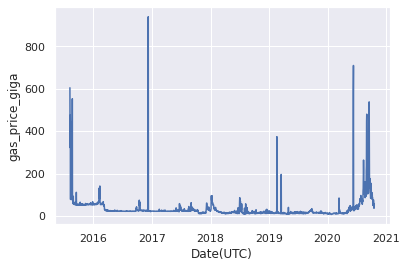

In [29]:
# plot the time series
sns.lineplot(x=data.index, y=data.gas_price_giga, data=data)

In [30]:
# naive model for ulti step

# evaluate one or more weekly forcatss against expected values
def evaluate_forcasts(actual:np.ndarray, predicted:np.ndarray):
    scores = []

    for i in range(actual.shape[1]):
        # calculate the mse
        mse = mean_squared_error(actual[:,i], predicted[:,i])
        rmse = np.sqrt(mse)
        scores.append(rmse)

    # calculate overall score
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores


In [31]:
# summarise scores
def summarise_scores(name, score, scores):
    s_scores = ', '.join([f"{s:0.1f}" for s in scores])
    print(f"{name}: {score:0.3f}==> {s_scores}")

In [32]:
def split_dataset(data:np.ndarray):
    train, test = data[2:1612], data[1612:1899]

    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))

    return train, test

In [33]:
train, test = split_dataset(data.values)
print(train.shape)
print(test.shape)

(230, 7, 3)
(41, 7, 3)


In [34]:
train[0, 0, 2]

475.467129048

In [35]:
# evaluate a single model
def evaluate_model(model_func, train:np.ndarray, test:np.ndarray):
    # history is a list of weekly data
    history = [x for x in train]

    # walk forweward validation over each week
    predictions = []

    for i in range(len(test)):
        # predict the week
        yhat_seq = model_func(history)
        predictions.append(yhat_seq)

        # get real observations and add to history for predicting next week
        history.append(test[i, :])
    predictions = np.array(predictions)

    # evaluate predictions days for each week
    score, scores = evaluate_forcasts(test[:, :, 2], predictions)

    return score, scores


In [36]:
# daily naive forcast
def daily_persistence(history):
    # get the data for the prior week
    last_week = history[-1]

    # get the gigawei for the last day
    value = last_week[-1, 2]

    # prepare 7 day forecast
    forecast = [value for _ in range(7)]
    return forecast

In [37]:
# weekly persistence model
def weekly_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    return last_week[:, 2]

In [38]:
# week one year ago persistence model
def week_one_year_ago_persistence(history):
# get the data for the prior week
    last_week = history[-52]
    return last_week[:, 2]

In [39]:
# define the names and functions for the models we wish to evaluate
models = dict()
models[' daily' ] = daily_persistence
models[' weekly' ] = weekly_persistence
models[' week-oya' ] = week_one_year_ago_persistence

 daily: 77.612==> 30.1, 38.1, 63.6, 109.8, 137.9, 52.8, 43.5
 weekly: 100.379==> 26.5, 35.5, 77.7, 149.6, 186.6, 58.7, 43.5
 week-oya: 100.349==> 53.1, 70.9, 104.8, 128.6, 158.6, 79.1, 60.8


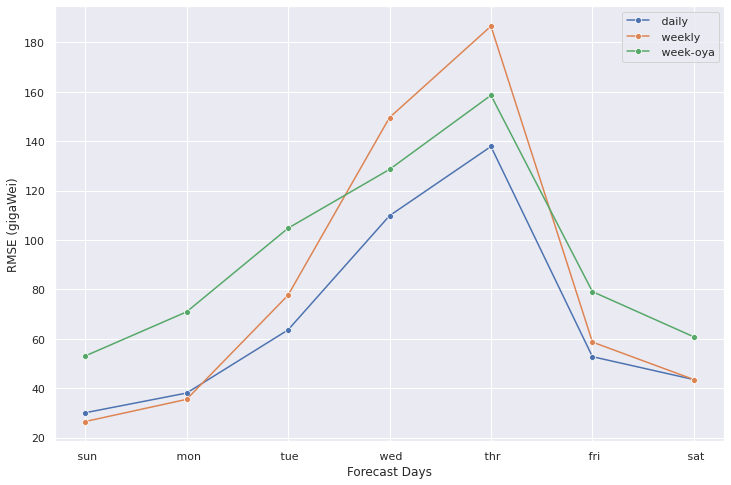

In [40]:
# evaluate each model
days = [' sun' , ' mon' , ' tue' , ' wed' , ' thr' , ' fri' , ' sat' ]
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_xlabel("Forecast Days")
ax.set_ylabel("RMSE (gigaWei)")
for name, func in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
    # summarize scores
    summarise_scores(name , score, scores) # plot scores
    sns.lineplot(x=days, y=scores, label=name, ax=ax, marker="o")
    # plt.plot(days, scores, marker='o' , label=name)
plt.show()    

In [41]:
####################### CNN HERE

global_result_dict = dict()

In [42]:
# CNN

# convert history into inputs and outputs
def to_supervised(train:np.ndarray, n_input:int, n_out=1):
    # flatten the data
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2]))
    X, Y = [], []

    in_start = 0

    # step ver history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out

        if out_end <= len(data):
            x_input = data[in_start:in_end, 2]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            Y.append(data[in_end:out_end, 2])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(Y)

In [43]:
# define the Learning Rate Scheduler
epoch_num = 200
initial_rate = 1e-3

def poly_decay(epoch):
    max_epochs = epoch_num
    baseLR = initial_rate
    power = 1.0
    
    alpha = baseLR * (1 - (epoch / float(max_epochs))) ** power
    return alpha


callbacks = [LearningRateScheduler(poly_decay),]
             #EpochCheckpoint(outputPath=dbBase)]

In [44]:
# train the model
def build_model_cnn(train, n_input, verbose, epochs, bs):
    # prepare the data
    trainx, trainy = to_supervised(train, n_input)

    # define params
    verbose, epochs, bs = verbose, epochs, bs
    n_timesteps, n_features, n_outputs = trainx.shape[1], \
                                         trainx.shape[2], \
                                         trainy.shape[1]

    # define the model
    model = Sequential()

    model.add(Conv1D(16, 3, activation="relu", input_shape=(n_timesteps, n_features)))
    model.add(MaxPool1D())
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))


    model.add(Dense(n_outputs))
    model.compile(loss="mse", optimizer=Adam(learning_rate=initial_rate ))

    # fit
    H = model.fit(trainx, trainy, epochs=epochs, batch_size=bs, verbose=verbose, callbacks=callbacks)
    return model, H

In [45]:
# train the model
def build_model_lstm(train, n_input, verbose, epochs, bs):
    # prepare the data
    trainx, trainy = to_supervised(train, n_input)

    # define params
    verbose, epochs, bs = verbose, epochs, bs
    n_timesteps, n_features, n_outputs = trainx.shape[1], \
                                         trainx.shape[2], \
                                         trainy.shape[1]

    # define the model
    model = Sequential()

    model.add(LSTM(16, activation='relu' , input_shape=(n_timesteps, n_features)))
    model.add(Dense(10, activation='relu' ))

    model.add(Dense(n_outputs))
    model.compile(loss="mse", optimizer=Adam(learning_rate=initial_rate))

    # fit
    H = model.fit(trainx, trainy, epochs=epochs, batch_size=bs, verbose=verbose, callbacks=callbacks)
    return model, H

In [46]:
def forecast(model, history, n_input):

    data = np.array(history)
    #print("this is data shape")
    #print(data.shape)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

    # retrieve last obs
    input_x = data[-n_input:, 2]

    # reshape
    input_x = input_x.reshape((1, len(input_x), 1))

    yhat = model.predict(input_x, verbose=0)

    yhat = yhat[0]
    return yhat

In [47]:
def evaluate_model(train:np.ndarray, test:np.ndarray, n_input, verbose, epochs, bs, build_model):
    # fit the model
    model, H = build_model(train, n_input, verbose, epochs, bs)

    # history is  alist of weekly data
    history = [x for x in train]

    # walk forward validation over each week
    predictions = []

    for i in range(len(test)):
        # preedict the week
        yhat_sequence = forecast(model, history, n_input)

        # store the predictions
        predictions.append(yhat_sequence)

        # get real observations and add to history
        history.append(test[i, :])

    # evaluate prediction days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forcasts(test[:,:,2], predictions)

    return score, scores, predictions, H

In [ ]:
train, test = split_dataset(data.values)
n_input = 14
verbose=1
epochs = 200
bs = 16

score, scores, preds, H = evaluate_model(train, test, n_input, verbose, epochs, bs, build_model_lstm)
summarise_scores('lstm', score, scores)


Epoch 1/200
100/100 [==============================] - 2s 24ms/step - loss: 1323.3306
Epoch 2/200
100/100 [==============================] - 2s 25ms/step - loss: 728.6062
Epoch 3/200
100/100 [==============================] - 2s 21ms/step - loss: 721.1357
Epoch 4/200
100/100 [==============================] - 2s 25ms/step - loss: 754.4993
Epoch 5/200
100/100 [==============================] - 3s 27ms/step - loss: 743.2194
Epoch 6/200
100/100 [==============================] - 2s 22ms/step - loss: 738.1468
Epoch 7/200
100/100 [==============================] - 2s 23ms/step - loss: 733.7532
Epoch 8/200
100/100 [==============================] - 2s 22ms/step - loss: 732.6693
Epoch 9/200
100/100 [==============================] - 3s 25ms/step - loss: 728.3861
Epoch 10/200
100/100 [==============================] - 3s 29ms/step - loss: 720.7029
Epoch 11/200
100/100 [==============================] - 3s 28ms/step - loss: 716.4742
Epoch 12/200
100/100 [==============================] - 2s 23m

In [26]:
global_result_dict['lstm'] = [score, scores, preds, H]

In [28]:
train, test = split_dataset(data.values)
n_input = 14
verbose=1
epochs = 200
bs = 16

score, scores, preds, H = evaluate_model(train, test, n_input, verbose, epochs, bs, build_model_cnn)
summarise_scores('cnn', score, scores)

Epoch 1/200
100/100 [==============================] - 0s 2ms/step - loss: 1488.2479
Epoch 2/200
100/100 [==============================] - 0s 2ms/step - loss: 1190.1547
Epoch 3/200
100/100 [==============================] - 0s 2ms/step - loss: 843.6282
Epoch 4/200
100/100 [==============================] - 0s 2ms/step - loss: 774.5601
Epoch 5/200
100/100 [==============================] - 0s 2ms/step - loss: 751.2827
Epoch 6/200
100/100 [==============================] - 0s 2ms/step - loss: 738.0918
Epoch 7/200
100/100 [==============================] - 0s 2ms/step - loss: 725.6659
Epoch 8/200
100/100 [==============================] - 0s 2ms/step - loss: 719.0753
Epoch 9/200
100/100 [==============================] - 0s 2ms/step - loss: 714.4938
Epoch 10/200
100/100 [==============================] - 0s 2ms/step - loss: 712.9339
Epoch 11/200
100/100 [==============================] - 0s 2ms/step - loss: 709.3387
Epoch 12/200
100/100 [==============================] - 0s 2ms/step - lo

In [29]:
global_result_dict['cnn'] = [score, scores, preds, H]

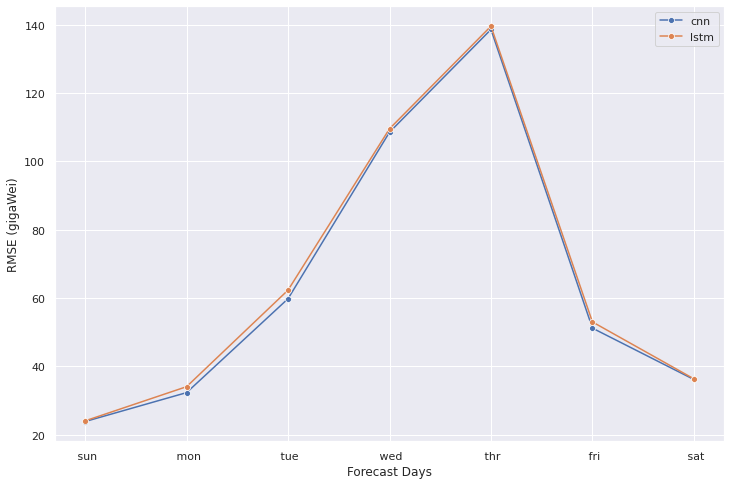

In [30]:
# plot scores
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_xlabel("Forecast Days")
ax.set_ylabel("RMSE (gigaWei)")
days = [' sun' , ' mon' , ' tue' , ' wed' , ' thr' , ' fri' , ' sat' ]

sns.lineplot(x=days, y=global_result_dict['cnn'][1], label='cnn', ax=ax, marker="o")
sns.lineplot(x=days, y=global_result_dict['lstm'][1], label='lstm', ax=ax, marker="o")
#plt.plot(days, scores, marker='o' , label=' cnn' )
plt.show()

In [31]:
cnn_preds = global_result_dict['cnn'][2].ravel()
lstm_preds = global_result_dict['lstm'][2].ravel()
test_data = test[:,:,2].ravel()

#df = pd.DataFrame(data={'test_data': list(test_data), 'cnn_prediction': list(cnn_preds)})
df = pd.DataFrame(data={'test_data': list(test_data), 'cnn_prediction': list(cnn_preds), 'lstm_prediction': list(lstm_preds)})

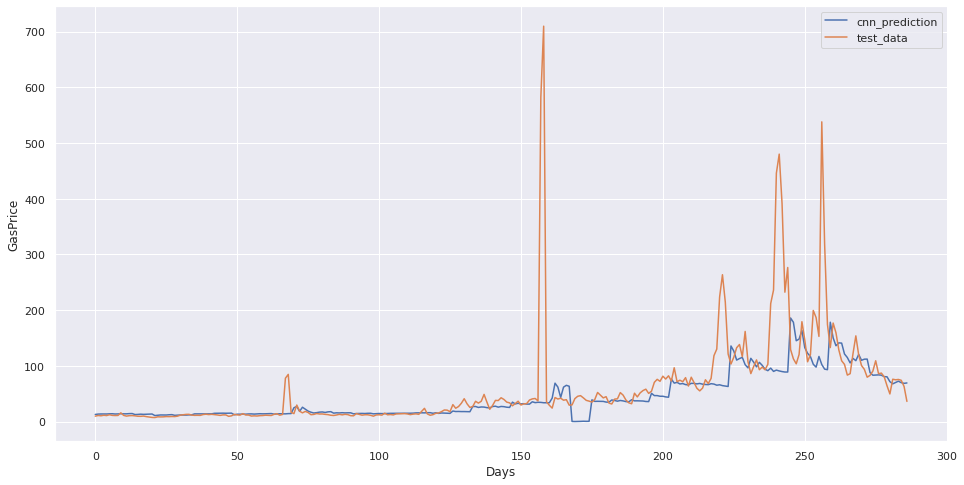

In [37]:
f, ax = plt.subplots(1,1, figsize=(16,8)) #type: Figure, axes.Axes
ax.set_xlabel("Days")
ax.set_ylabel("GasPrice")

sns.lineplot(data=df, label='cnn_prediction', y = 'cnn_prediction',x=list(range(len(df['cnn_prediction']))))
#sns.lineplot(data=df, label='lstm_prediction', y = 'lstm_prediction',x=list(range(len(df['lstm_prediction']))))
sns.lineplot(data=df, label='test_data', y = 'test_data',x=list(range(len(df['test_data']))))

plt.show()

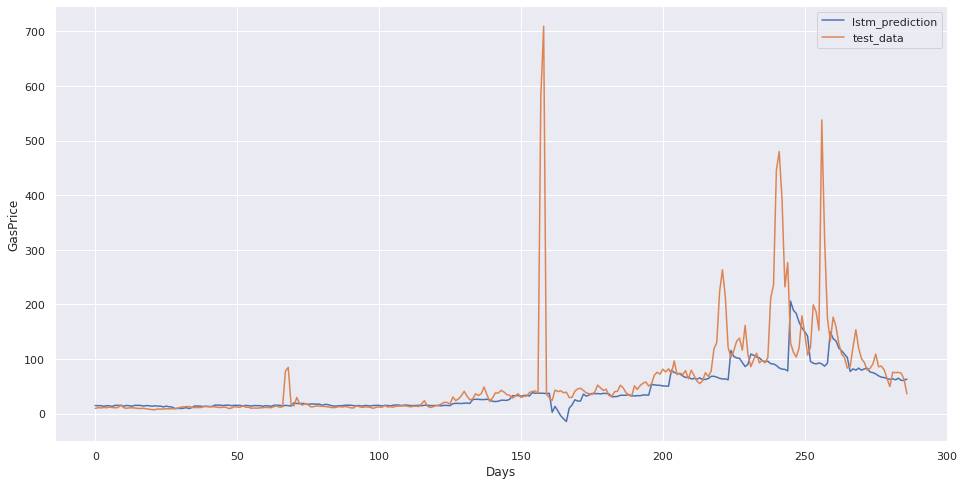

In [38]:
f, ax = plt.subplots(1,1, figsize=(16,8)) #type: Figure, axes.Axes
ax.set_xlabel("Days")
ax.set_ylabel("GasPrice")


sns.lineplot(data=df, label='lstm_prediction', y = 'lstm_prediction',x=list(range(len(df['lstm_prediction']))))
sns.lineplot(data=df, label='test_data', y = 'test_data',x=list(range(len(df['test_data']))))

plt.show()

## FBPROPHET SECTION

In [150]:
import fbprophet

In [151]:
data.head()

,time_stamp,gas_price,gas_price_giga
Date(UTC),,,
2015-08-07,1438905600,604684154870,604.684155
2015-08-08,1438992000,322713574989,322.713575
2015-08-09,1439078400,475467129048,475.467129
2015-08-10,1439164800,421654904254,421.654904
2015-08-11,1439251200,77838819162,77.838819


In [152]:
df_prophet = data.drop(['gas_price', 'time_stamp'], axis=1)[2:]
df_prophet.shape

(1899, 1)

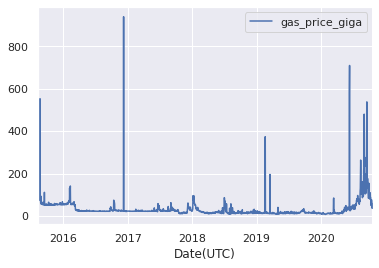

In [153]:
df_prophet.plot()

In [154]:
from fbprophet import Prophet

In [155]:
prophet_model = Prophet()

In [156]:
df_prophet.columns

Index(['gas_price_giga'], dtype='object')

In [157]:
df_prophet.reset_index(inplace=True)
df_prophet.head()

,Date(UTC),gas_price_giga
0,2015-08-09,475.467129
1,2015-08-10,421.654904
2,2015-08-11,77.838819
3,2015-08-12,444.902379
4,2015-08-13,268.683475


In [158]:
df_prophet.rename(columns={'Date(UTC)': 'ds', 'gas_price_giga': 'y'}, inplace=True)
df_prophet.head()

,ds,y
0,2015-08-09,475.467129
1,2015-08-10,421.654904
2,2015-08-11,77.838819
3,2015-08-12,444.902379
4,2015-08-13,268.683475


In [160]:
# use data for non 2020 years to fit to prophet model
df_prophet_train = df_prophet[0:1606]
df_prophet_test = df_prophet[1606:]
df_prophet_train.tail()

,ds,y
1601,2019-12-27,12.102235
1602,2019-12-28,11.826354
1603,2019-12-29,11.250754
1604,2019-12-30,11.988751
1605,2019-12-31,14.031976


In [162]:
df_prophet_train.shape
df_prophet_test.shape

(293, 2)

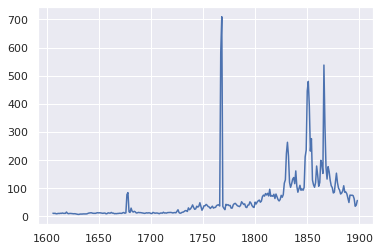

In [163]:
# plot just the test part of the data
df_prophet_test['y'].plot()

In [164]:
prophet_model = Prophet()

In [165]:
prophet_model.fit(df_prophet_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [166]:
future_dates = prophet_model.make_future_dataframe(periods=293)

In [167]:
future_dates.head()

,ds
0,2015-08-09
1,2015-08-10
2,2015-08-11
3,2015-08-12
4,2015-08-13


In [168]:
all_preds = prophet_model.predict(future_dates)

In [169]:
all_preds.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-08-09,119.792346,90.323034,173.460251,119.792346,119.792346,14.120008,14.120008,14.120008,-1.763090,-1.763090,-1.763090,15.883098,15.883098,15.883098,0.0,0.0,0.0,133.912353
1,2015-08-10,119.087844,93.744742,180.034001,119.087844,119.087844,16.473125,16.473125,16.473125,-0.277194,-0.277194,-0.277194,16.750319,16.750319,16.750319,0.0,0.0,0.0,135.560969
2,2015-08-11,118.383343,91.303985,178.164487,118.383343,118.383343,16.976969,16.976969,16.976969,-0.409695,-0.409695,-0.409695,17.386664,17.386664,17.386664,0.0,0.0,0.0,135.360312
3,2015-08-12,117.678841,95.490325,177.290531,117.678841,117.678841,18.430053,18.430053,18.430053,0.655378,0.655378,0.655378,17.774674,17.774674,17.774674,0.0,0.0,0.0,136.108894
4,2015-08-13,116.974339,99.725704,180.024947,116.974339,116.974339,20.838042,20.838042,20.838042,2.935977,2.935977,2.935977,17.902065,17.902065,17.902065,0.0,0.0,0.0,137.812381


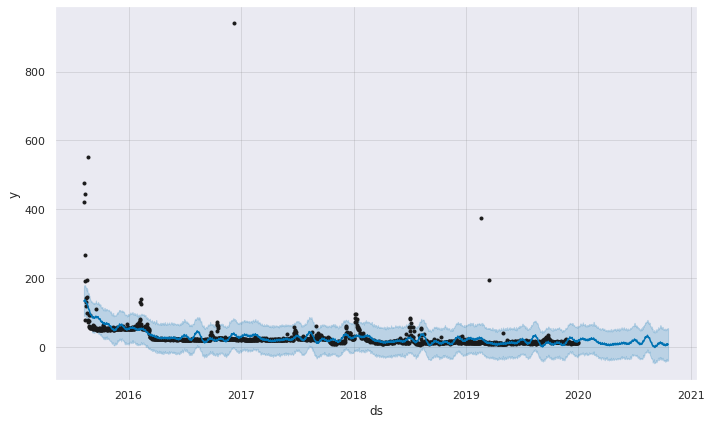

In [170]:
prophet_model.plot(all_preds);

In [180]:
predicted_test_data = all_preds['yhat'][1606:]
predicted_test_data.shape

(293,)

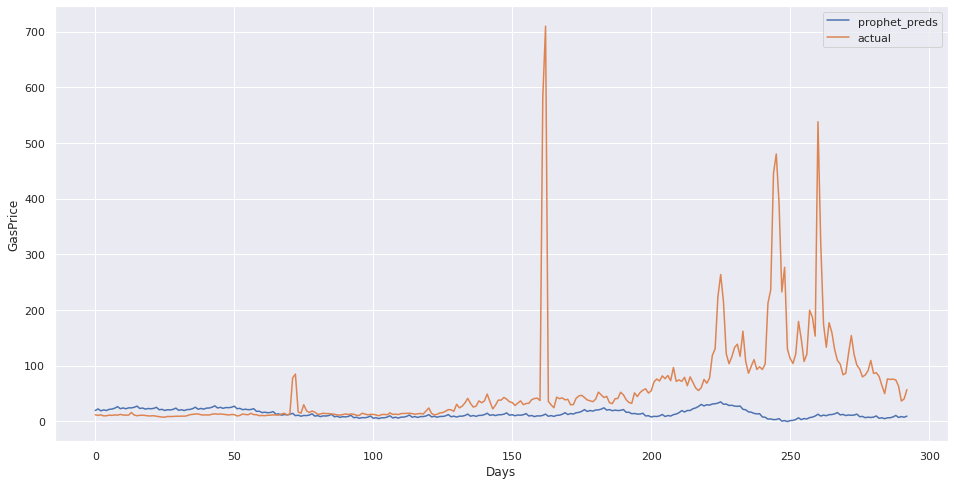

In [181]:
f, ax = plt.subplots(1,1, figsize=(16,8)) #type: Figure, axes.Axes
ax.set_xlabel("Days")
ax.set_ylabel("GasPrice")
x = range(len(df_prophet_test['y']))

sns.lineplot(x=x, y=predicted_test_data, label="prophet_preds", ax=ax)
sns.lineplot(x=x, y=df_prophet_test['y'], label="actual", ax=ax)
plt.show()

In [175]:
len(df_prophet_test['y'])

293

In [98]:
df['test_data'].shape

(287,)

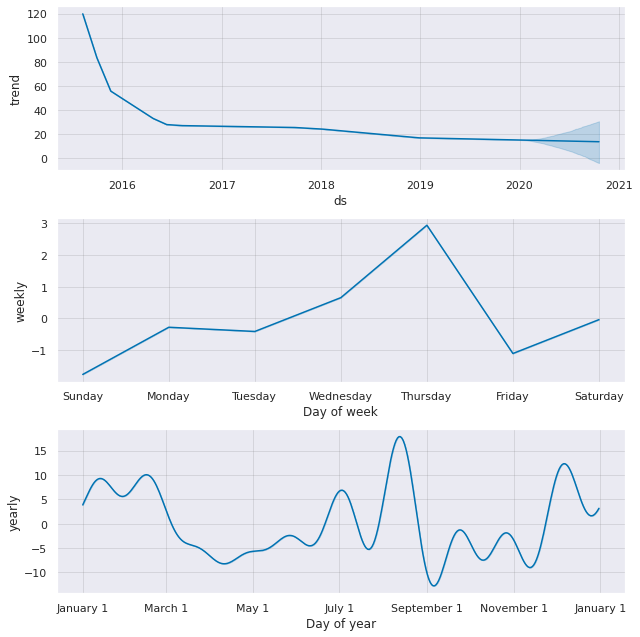

In [179]:
prophet_model.plot_components(all_preds);

## Regression Section

In [314]:
data.head()

,time_stamp,gas_price,gas_price_giga
Date(UTC),,,
2015-08-07,1438905600,604684154870,604.684155
2015-08-08,1438992000,322713574989,322.713575
2015-08-09,1439078400,475467129048,475.467129
2015-08-10,1439164800,421654904254,421.654904
2015-08-11,1439251200,77838819162,77.838819


In [315]:
train_xgb, test_xgb = split_dataset(data.values)

In [316]:
train_xgb.shape

(230, 7, 3)

In [317]:
trainx_xgb, trainy_xgb = to_supervised(train_xgb, n_input=14, n_out=1)

In [318]:
trainx_xgb.shape

(1596, 14, 1)

In [319]:
trainy_xgb.shape

(1596, 1)

In [320]:
trainy_xgb.min()

8.072326506

In [321]:
test_xgb.shape

(41, 7, 3)

In [322]:
test_xgb_reshaped = test_xgb.reshape(test_xgb.shape[0] * test_xgb.shape[1], test_xgb.shape[2])
test_xgb_reshaped.shape
X, Y = [], []
n_input = 14
n_out = 1
in_start = 0

# step ver history one time step at a time
for _ in range(len(test_xgb_reshaped)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out

    if out_end <= len(test_xgb_reshaped):
        x_input = test_xgb_reshaped[in_start:in_end, 2]
        x_input = x_input.reshape((len(x_input), 1))
        X.append(x_input)
        Y.append(test_xgb_reshaped[in_end:out_end, 2])
    # move along one time step
    in_start += 1
X = np.array(X).squeeze()    
Y = np.array(Y)

In [323]:

from sklearn.metrics import accuracy_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso 
from sklearn.linear_model import ElasticNet 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor



In [324]:
model_dict = {
    'xgb': XGBRegressor(),
    'linreg': LinearRegression(),
    'lasso': Lasso(),
    'elastic': ElasticNet(),
    'dtree': DecisionTreeRegressor(),
    'knn': KNeighborsRegressor(),
    'svr': SVR(),
    'forest': RandomForestRegressor(),
    'gb': GradientBoostingRegressor(),
    'extratree': ExtraTreesRegressor(),
    'ada': AdaBoostRegressor()
}

In [325]:
mse_dict = {}
preds_dict = {}
for name, model in model_dict.items():
  model.fit(trainx_xgb.squeeze(), trainy_xgb)
  preds = model.predict(X)
  mse = mean_squared_error(Y, preds)
  mse_dict[name] = np.sqrt(mse)
  preds_dict[name] = preds


[05:14:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A col

In [339]:
type(next(jj))

tuple

In [326]:
mse_dict



{'ada': 73.9127123252381,
 'dtree': 81.11391287595077,
 'elastic': 73.74837595632553,
 'extratree': 79.25468210136619,
 'forest': 77.94403023409757,
 'gb': 79.81914407863371,
 'knn': 81.81210976701311,
 'lasso': 73.77169082778578,
 'linreg': 73.72050075892014,
 'svr': 94.57475240053068,
 'xgb': 79.63023769412366}

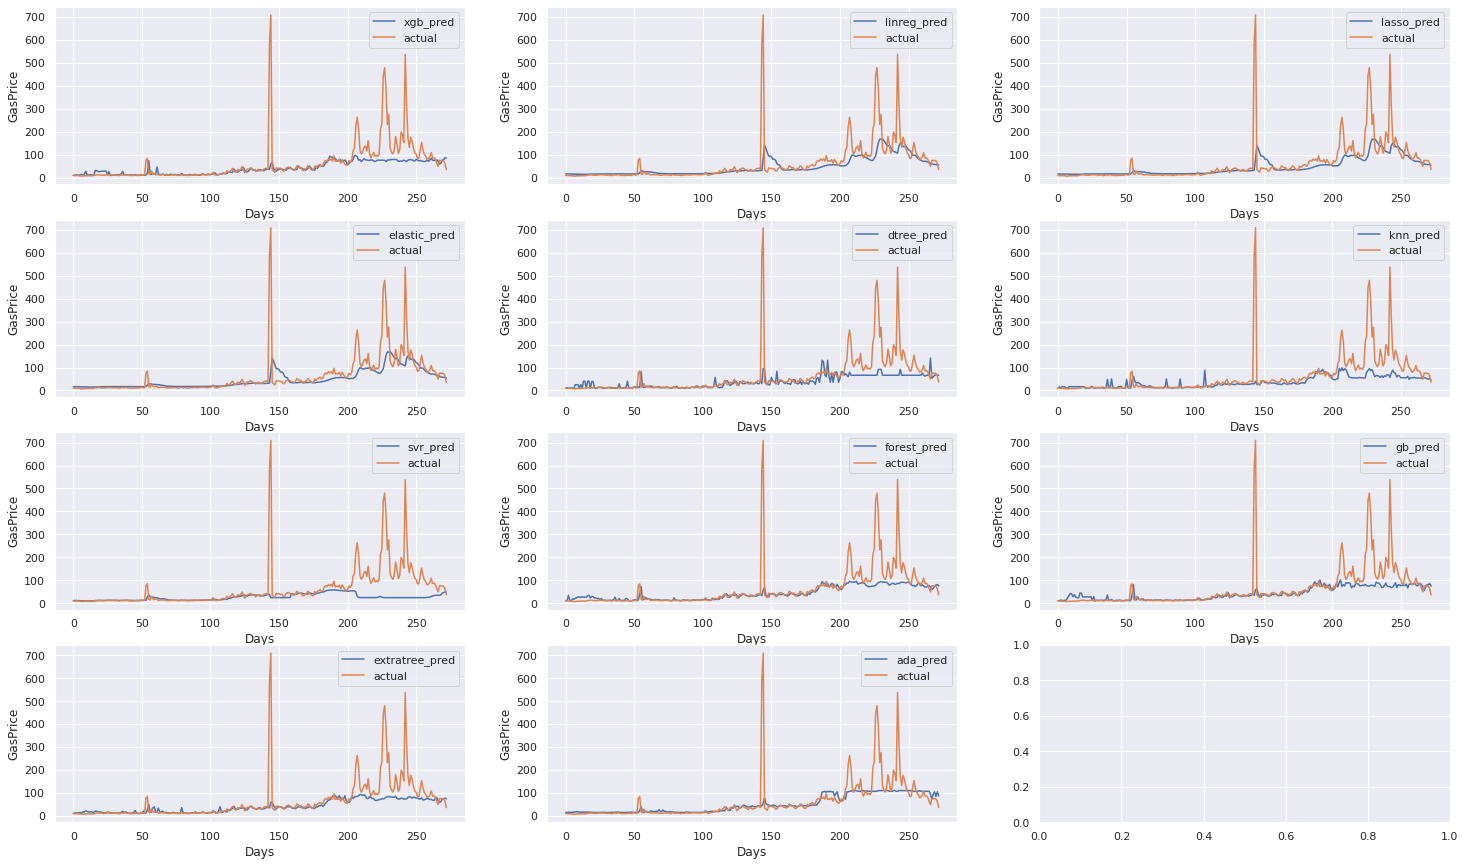

In [343]:
f, ax = plt.subplots(4,3, figsize=(25,15)) #type: Figure, axes.Axes
x = range(len(X))
model_preds_iter = iter(preds_dict.items())

model_count = 0
for row_num in range(4):
  for col_num in range(3):
    try:
      model, rmse = next(model_preds_iter)
      sns.lineplot(x=x, y=preds_dict[model].ravel(), label=f"{model}_pred",ax = ax[row_num][col_num])
      sns.lineplot(x=x, y=Y.ravel(), label="actual", ax = ax[row_num][col_num])
      ax[row_num][col_num].set_xlabel("Days")
      ax[row_num][col_num].set_ylabel("GasPrice")
    except:
      pass  

plt.show()

In [244]:
len(X)

273

## Classical TS

In [311]:
data.head()

,time_stamp,gas_price,gas_price_giga
Date(UTC),,,
2015-08-07,1438905600,604684154870,604.684155
2015-08-08,1438992000,322713574989,322.713575
2015-08-09,1439078400,475467129048,475.467129
2015-08-10,1439164800,421654904254,421.654904
2015-08-11,1439251200,77838819162,77.838819


# ARIMA FROM JLEE

Text(0.5, 0, 'Time')

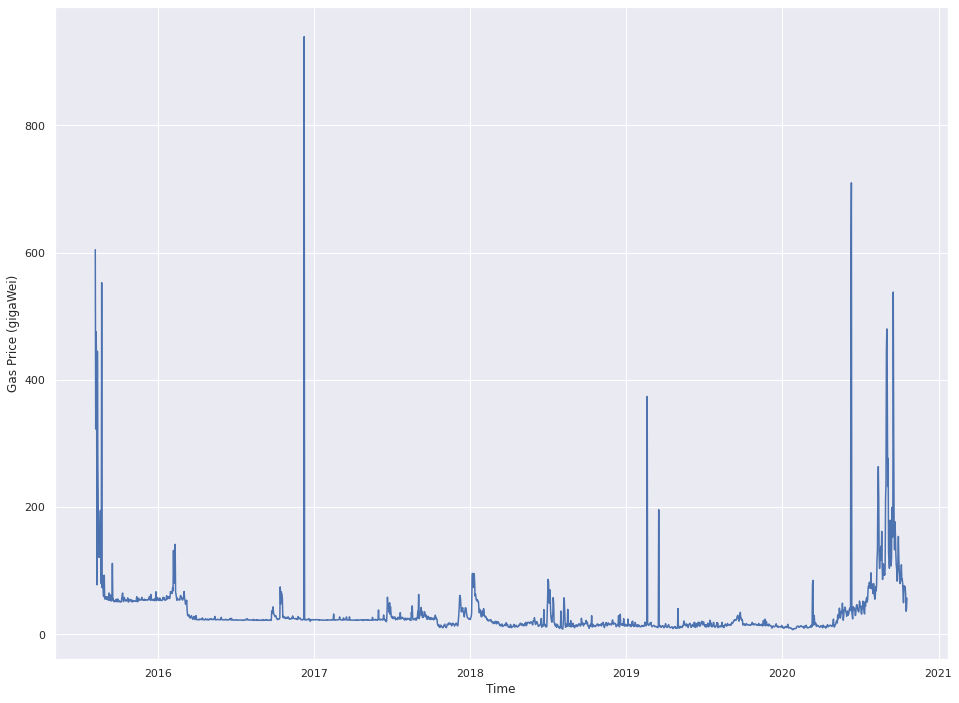

In [ ]:
roll_mean = data['gas_price_giga'].rolling(window=30).mean()
roll_std = data['gas_price_giga'].rolling(window=30).std()
f, ax = plt.subplots(1,1, figsize=(16, 12))

sns.lineplot(x=data.index, y=data['gas_price_giga'], ax=ax)
ax.set_ylabel("Gas Price (gigaWei)")
ax.set_xlabel("Time")
# sns.lineplot(x=data.index, y=roll_mean, ax=ax)
# sns.lineplot(x=data.index, y=roll_std, ax=ax)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


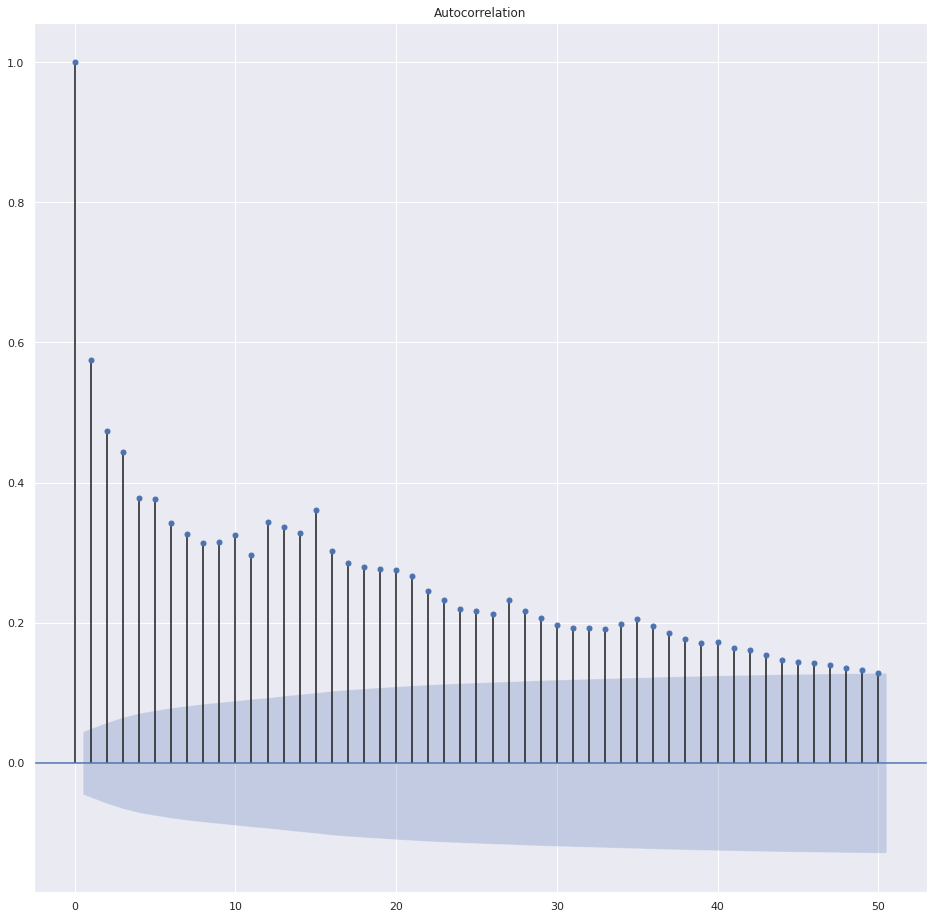

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
series = data['gas_price_giga']
lags=50
f, ax = plt.subplots(1, 1, figsize=(16, 16))
plot_acf(series, lags=lags, ax=ax);

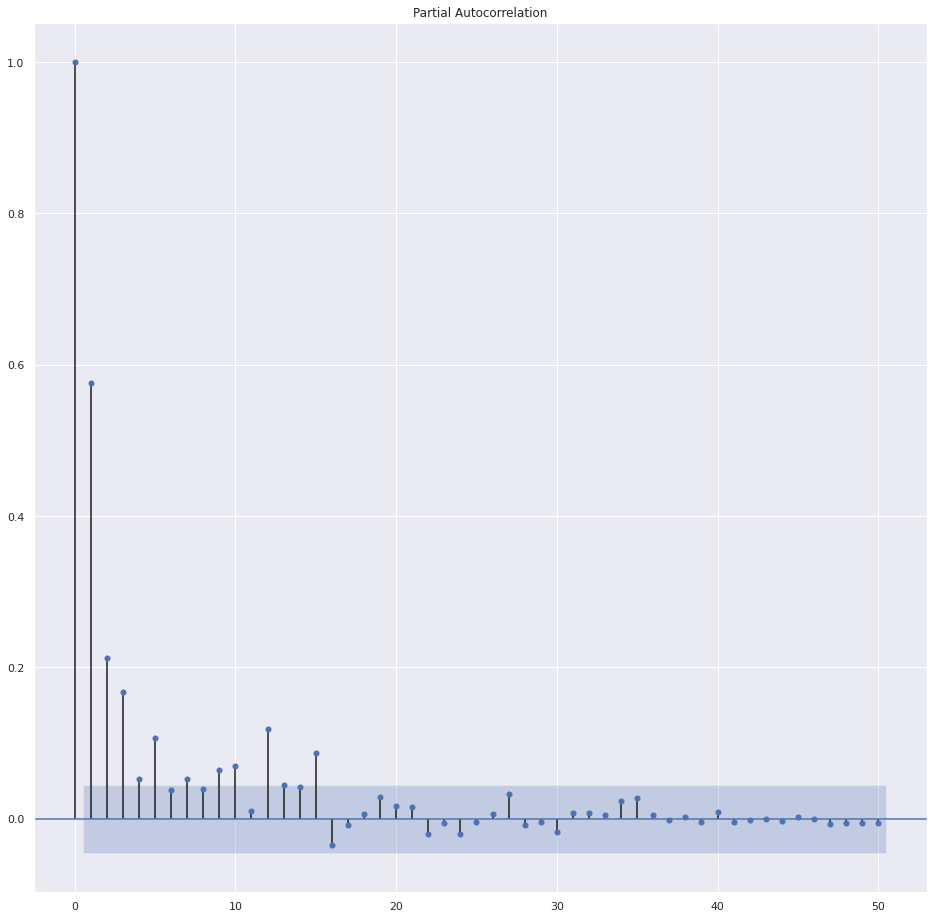

In [ ]:
lags=50
f, ax = plt.subplots(1, 1, figsize=(16, 16))
plot_pacf(series, lags=lags, ax=ax);


In [ ]:
# grid search ARIMA parameters for time series 
import warnings 
from math import sqrt 
from pandas import read_csv 
from pandas import datetime 
from statsmodels.tsa.arima_model import ARIMA 
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q) 
def evaluate_arima_model(X, arima_order): 
  # prepare training dataset 
  train_size = int(len(X) * 0.66) 
  train, test = X[0:train_size], X[train_size:] 
  history = [x for x in train] 
  
  # make predictions 
  predictions = list() 
  for t in range(len(test)): 
    model = ARIMA(history, order=arima_order) 
    model_fit = model.fit(disp=0) 
    yhat = model_fit.forecast()[0] 
    predictions.append(yhat)
    history.append(test[t])

  # calculate out of sample error 
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

# evaluate combinations of p, d and q values for an ARIMA model 
def evaluate_models(dataset, p_values, d_values, q_values): 
  dataset = dataset.astype('float32' ) 
  best_score, best_cfg = float("inf"), None 
  
  for p in p_values: 
    for d in d_values: 
      for q in q_values:
        order = (p,d,q) 
        try:
          #print("I am here")
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print(' ARIMA%s RMSE=%.3f' % (order,rmse)) 
        except:
          continue
  print(' Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))    

In [ ]:
# evaluate parameters 
p_values = range(0, 11)
d_values = range(0, 3) 
q_values = range(0, 11) 
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

 ARIMA(0, 0, 0) RMSE=64.330
 ARIMA(0, 0, 1) RMSE=52.202
 ARIMA(0, 0, 2) RMSE=51.076
 ARIMA(0, 0, 3) RMSE=49.786
 ARIMA(0, 0, 4) RMSE=49.296
 ARIMA(0, 0, 5) RMSE=49.459
 ARIMA(0, 0, 6) RMSE=49.441
 ARIMA(0, 0, 7) RMSE=49.133
 ARIMA(0, 0, 8) RMSE=48.960
 ARIMA(0, 0, 9) RMSE=49.080
 ARIMA(0, 0, 10) RMSE=49.089
 ARIMA(0, 1, 0) RMSE=48.149
 ARIMA(0, 1, 1) RMSE=48.794
 ARIMA(0, 2, 0) RMSE=72.768
 ARIMA(0, 2, 1) RMSE=48.190
 ARIMA(1, 0, 0) RMSE=46.563
 ARIMA(1, 0, 1) RMSE=48.511
 ARIMA(1, 1, 0) RMSE=50.302
 ARIMA(1, 1, 1) RMSE=47.715
 ARIMA(1, 1, 2) RMSE=47.819
 ARIMA(1, 1, 8) RMSE=48.157
 ARIMA(1, 2, 0) RMSE=67.346
 ARIMA(2, 0, 0) RMSE=48.191
 ARIMA(2, 1, 0) RMSE=50.556
 ARIMA(2, 1, 1) RMSE=47.939
 ARIMA(2, 1, 8) RMSE=48.087


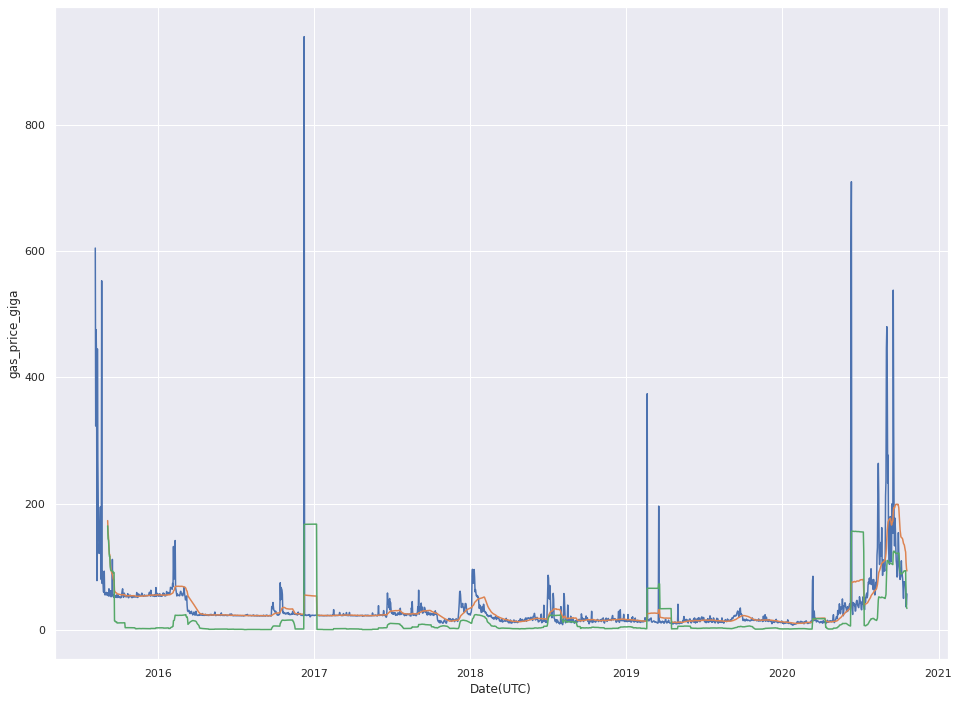

In [ ]:
roll_mean = data['gas_price_giga'].rolling(window=30).mean()
roll_std = data['gas_price_giga'].rolling(window=30).std()
f, ax = plt.subplots(1,1, figsize=(16, 12))

sns.lineplot(x=data.index, y=data['gas_price_giga'], ax=ax)
sns.lineplot(x=data.index, y=roll_mean, ax=ax)
sns.lineplot(x=data.index, y=roll_std, ax=ax)

In [ ]:
from statsmodels.tsa.stattools import adfuller

df_test = adfuller(data['gas_price_giga'])
df_out = pd.Series(df_test[0:4], index=['Test_statistic', 'p_value', 'lag_used', 'observations'])

for k, v in df_test[4].items():
  df_out[f"critical_value_{k}"] = v
print(df_out)

# null = not stationary
# reject null, so data is somwhat stationary

Test_statistic       -7.127610e+00
p_value               3.586184e-10
lag_used              1.500000e+01
observations          1.885000e+03
critical_value_1%    -3.433824e+00
critical_value_5%    -2.863075e+00
critical_value_10%   -2.567587e+00
dtype: float64


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

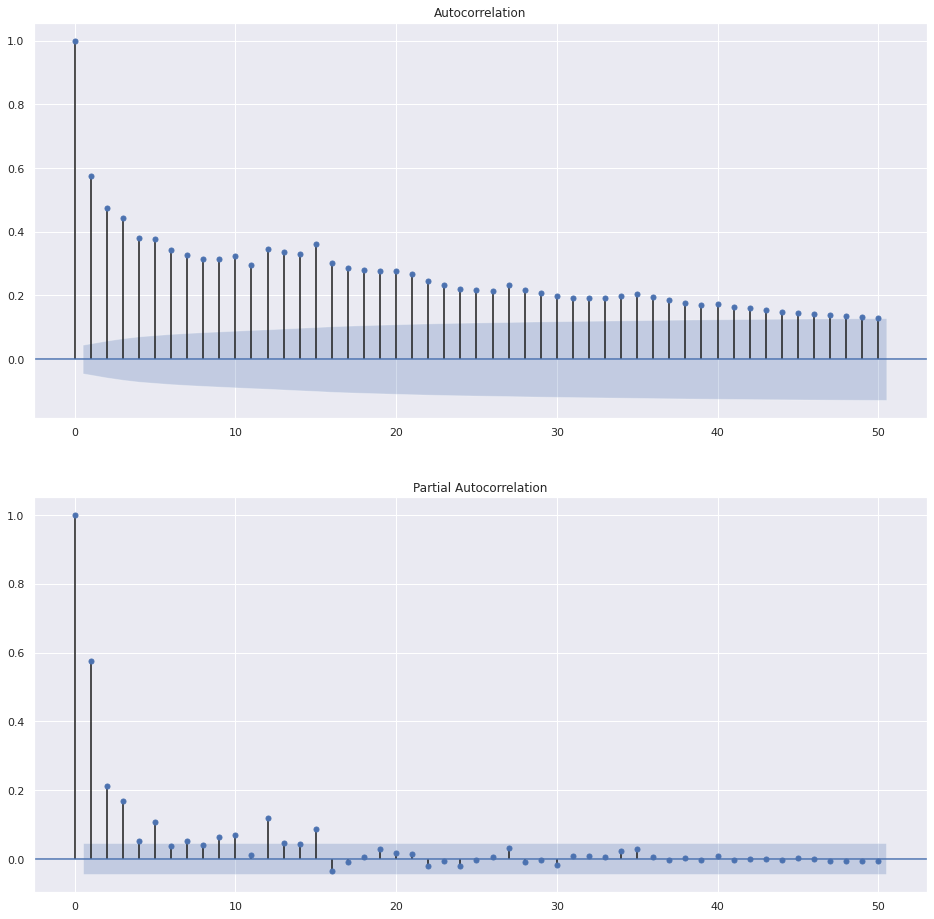

In [ ]:
lags=50
f, ax = plt.subplots(2, 1, figsize=(16, 16))
plot_acf(data['gas_price_giga'], lags=lags, ax=ax[0])
plot_pacf(data['gas_price_giga'], lags=lags, ax=ax[1]);

In [ ]:
from pandas.plotting import autocorrelation_plot

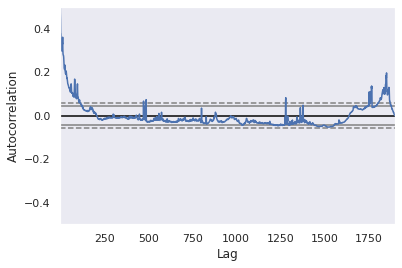

In [ ]:
autocorrelation_plot(data['gas_price_giga'])
plt.ylim(-0.5, 0.5)
plt.show()

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.6MB/s 
     |████████████████████████████████| 8.7MB 48.1MB/s 
     |████████████████████████████████| 808kB 47.3MB/s 
     |████████████████████████████████| 2.1MB 54.1MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: setuptools 50.3.0
    Uninstalling setuptools-50.3.0:
      Successfully uninstalled setuptools-50.3.0
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [ ]:
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
C

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19983.715, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19699.269, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19415.440, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19981.788, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19354.934, Time=0.78 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19356.379, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19355.844, Time=1.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19359.093, Time=0.71 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19531.199, Time=0.58 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19357.166, Time=1.56 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=19353.628, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19413.979, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=19697.388, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=19355.067, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0

In [ ]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1901
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -9673.814
Date:                Fri, 23 Oct 2020   AIC                          19353.628
Time:                        02:21:48   BIC                          19370.277
Sample:                             0   HQIC                         19359.757
                               - 1901                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2463      0.007     33.592      0.000       0.232       0.261
ma.L1         -0.8683      0.006   -143.538      0.000      -0.880      -0.856
sigma2      1547.9183      4.926    314.238      0.000    1538.264    1557.573
===================================================================================
Ljung-Box (Q):                       72.23   Jarque-Bera (JB):           3497742.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             9.26
Prob(H) (two-sided):                  0.00   Kurtosis:                       212.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
new_data = data['gas_price_giga']
train, test = new_data[2:1612], new_data[1612:1899]
train.shape

(1610,)

In [ ]:
model = ARIMA(train, order=(1,0,1))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [ ]:
results = model.fit()

In [ ]:
start = len(train)
end = len(train) + len(test) - 1

In [ ]:
preds = results.predict(start, end).rename('predictions')

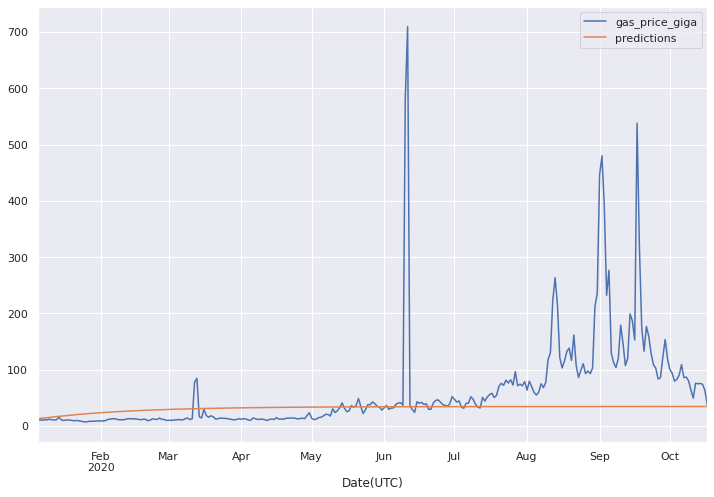

In [ ]:
test.plot(figsize=(12,8), legend=True)
preds.plot(legend=True)

In [ ]:
preds

2020-01-05    13.333231
2020-01-06    13.707299
2020-01-07    13.921119
2020-01-08    14.325219
2020-01-09    14.768124
                ...    
2020-10-13    34.739956
2020-10-14    34.740346
2020-10-15    34.740726
2020-10-16    34.741097
2020-10-17    34.741458
Freq: D, Name: predictions, Length: 287, dtype: float64

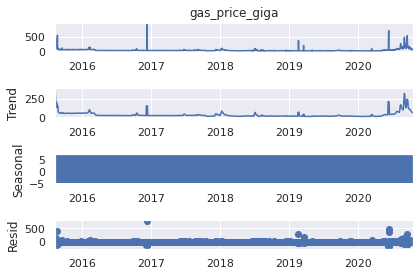

In [ ]:
r = seasonal_decompose(data['gas_price_giga'], model='add')
r.plot();

In [ ]:
r1 = auto_arima(data['gas_price_giga'], seasonal=False, trace=True)
r1.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19357.166, Time=1.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19983.715, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19699.269, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19415.440, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19981.788, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19355.844, Time=1.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19359.093, Time=0.69 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19354.934, Time=0.76 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19356.379, Time=1.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19531.199, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=19353.628, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19413.979, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=19697.388, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=19355.067, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1901
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -9673.814
Date:                Fri, 23 Oct 2020   AIC                          19353.628
Time:                        03:00:06   BIC                          19370.277
Sample:                             0   HQIC                         19359.757
                               - 1901                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2463      0.007     33.592      0.000       0.232       0.261
ma.L1         -0.8683      0.006   -143.538      0.000      -0.880      -0.856
sigma2      1547.9183      4.926    314.238      0.000    1538.264    1557.573
===================================================================================
Ljung-Box (Q):                       72.23   Jarque-Bera (JB):           3497742.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             9.26
Prob(H) (two-sided):                  0.00   Kurtosis:                       212.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

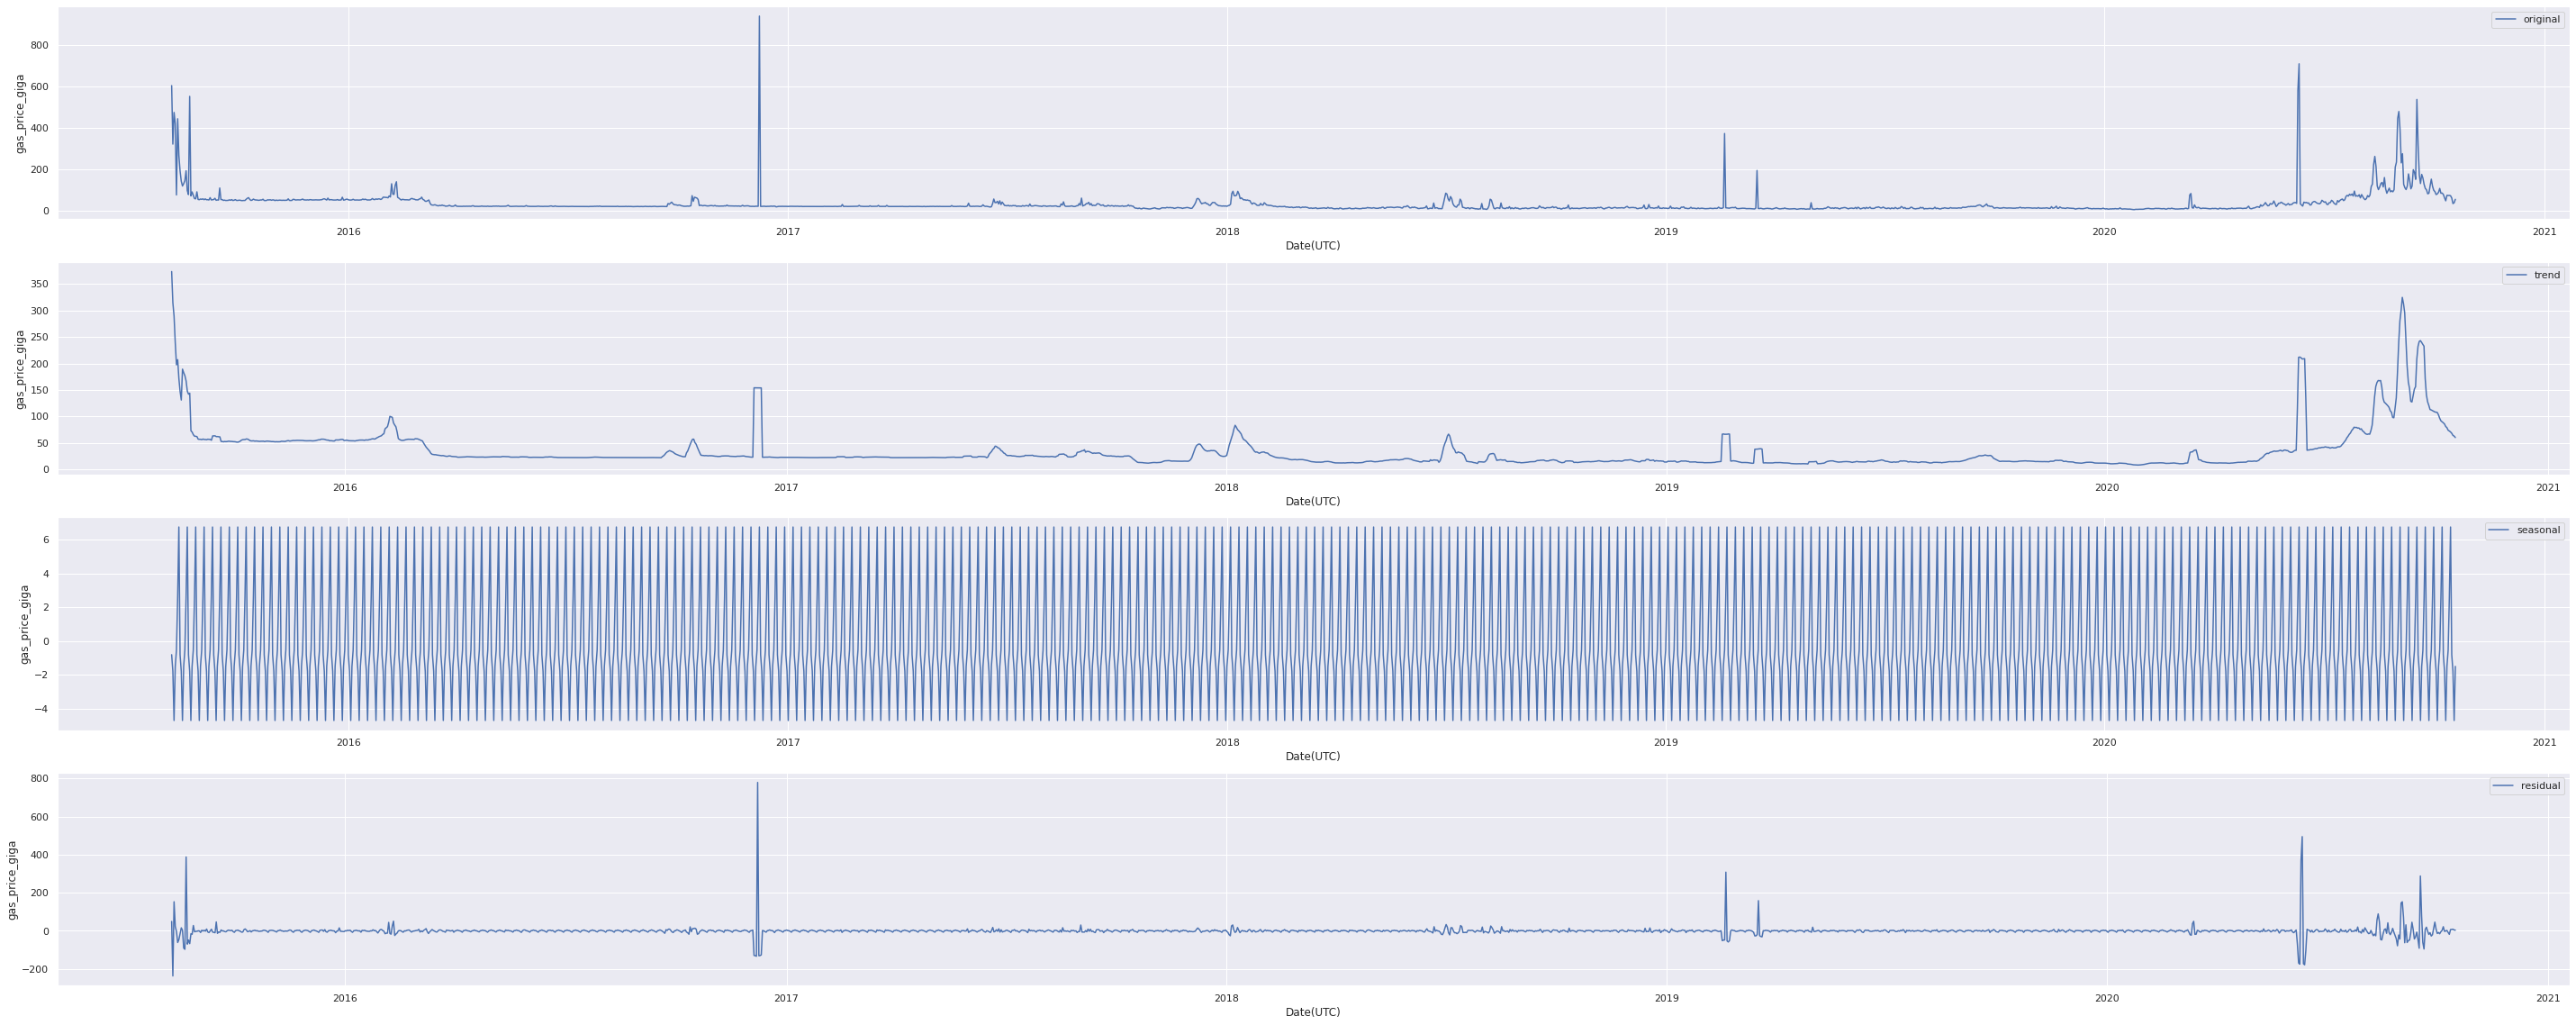

In [ ]:

decomposition = seasonal_decompose(data['gas_price_giga'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

f, ax = plt.subplots(4, 1, figsize=(50, 20))
sns.lineplot(x=data.index, y=data['gas_price_giga'], ax=ax[0], label="original")
sns.lineplot(x=data.index, y=trend, ax=ax[1], label="trend")
sns.lineplot(x=data.index, y=seasonal, ax=ax[2], label="seasonal")
sns.lineplot(x=data.index, y=residual, ax=ax[3], label="residual")